In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv("ticket_price_dataset.csv")

# Define features (X) and target (y)
X = df.drop("ticket_price", axis=1)
y = df["ticket_price"]

# Categorical and numerical features
categorical_features = ['event_type', 'location', 'event_day']
numeric_features = ['organizer_rating', 'attendance', 'duration', 'past_revenue']

# Preprocessing: One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'  # keep numeric features as they are
)

# Create a pipeline: preprocessing + linear regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # manual RMSE

# Output evaluation scores
print("R² Score:", r2)
print("RMSE:", rmse)


R² Score: 0.8103817424642938
RMSE: 24.920097694960663


In [5]:
# Example: new event data (raw, like user input)
new_event = pd.DataFrame({
    'event_type': ['Tech'],
    'location': ['Delhi'],
    'organizer_rating': [4.7],
    'attendance': [500],
    'duration': [5],
    'past_revenue': [75000],
    'event_day': ['Sunday']
})

# Predict ticket price using the trained pipeline (auto-preprocessing)
suggested_price = model.predict(new_event)

# Display result
print(f"Suggested Ticket Price: ₹{suggested_price[0]:.2f}")


Suggested Ticket Price: ₹267.00


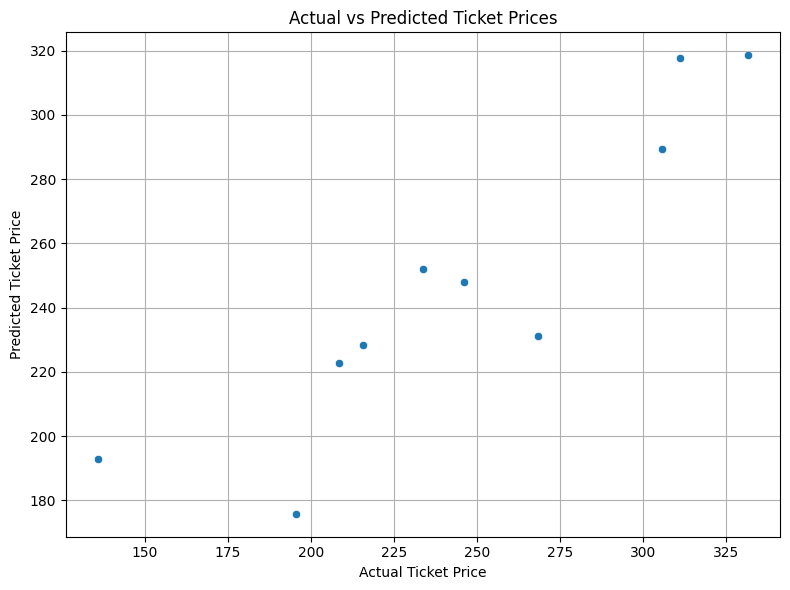

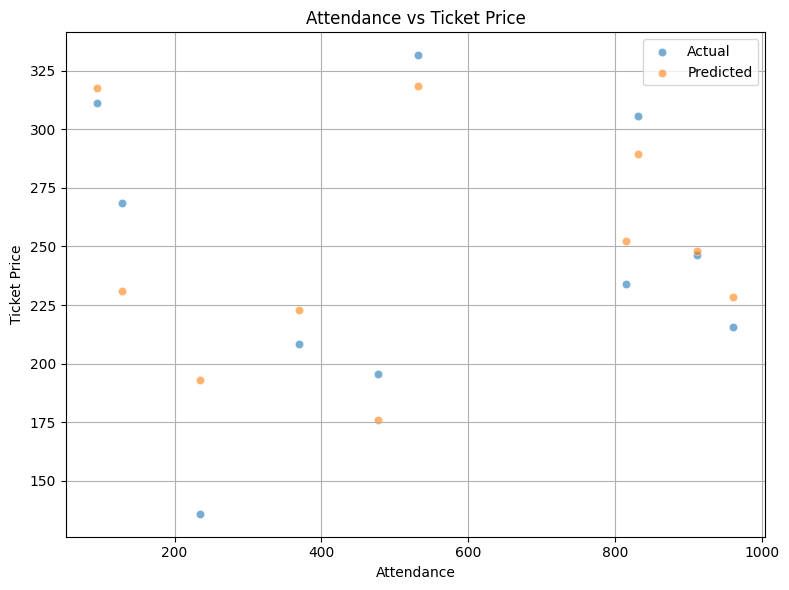

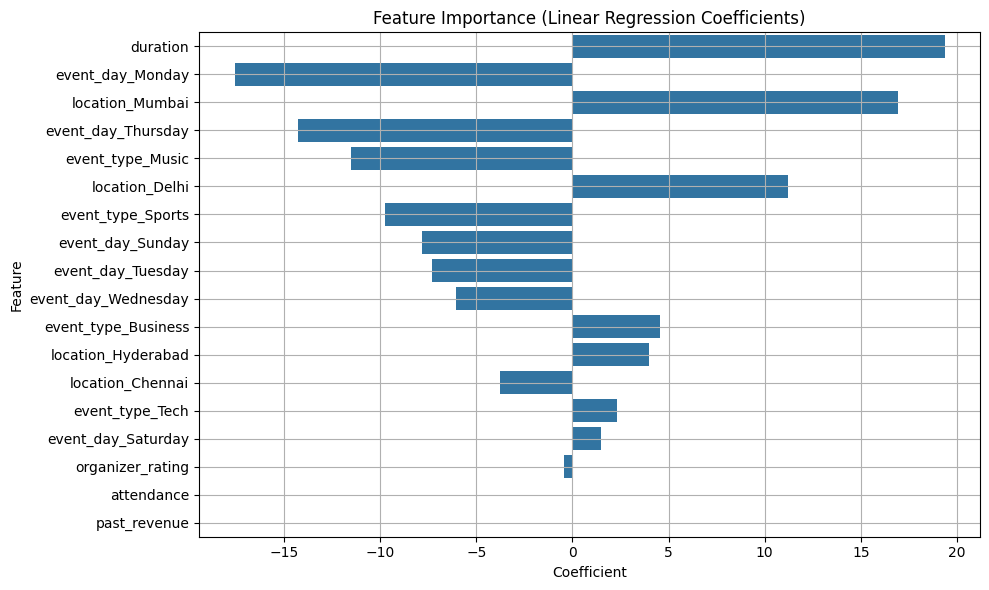

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add predictions to a copy of the test set
X_test_copy = X_test.copy()
X_test_copy['Actual Price'] = y_test.values
X_test_copy['Predicted Price'] = y_pred
X_test_copy['Error'] = X_test_copy['Actual Price'] - X_test_copy['Predicted Price']

# Plot 1: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Ticket Price")
plt.ylabel("Predicted Ticket Price")
plt.title("Actual vs Predicted Ticket Prices")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Attendance vs Ticket Price
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X_test_copy, x="attendance", y="Actual Price", label="Actual", alpha=0.6)
sns.scatterplot(data=X_test_copy, x="attendance", y="Predicted Price", label="Predicted", alpha=0.6)
plt.title("Attendance vs Ticket Price")
plt.xlabel("Attendance")
plt.ylabel("Ticket Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: Feature Importance
# Only if you're using OneHotEncoder and have access to the names
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(['event_type', 'location', 'event_day'])
all_feature_names = list(ohe_feature_names) + ['organizer_rating', 'attendance', 'duration', 'past_revenue']

coefficients = model.named_steps['regressor'].coef_

feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title("Feature Importance (Linear Regression Coefficients)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
!pip install mysql-connector-python



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
import mysql.connector
from datetime import datetime
import numpy as np

# Connect to MySQL
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="survi09mukh",
    database="eventchain"
)
cursor = db.cursor()

# Example new event input
new_event = pd.DataFrame({
    'event_type': ['Tech'],
    'location': ['Delhi'],
    'organizer_rating': [4.7],
    'attendance': [500],
    'duration': [5],
    'past_revenue': [75000],
    'event_day': ['Sunday']
})

# Predict
predicted_price = model.predict(new_event)[0]
confidence = np.std(y_pred)  # crude confidence estimate (or use prediction interval later)

# Insert into DB
sql = """
INSERT INTO ticket_predictions (
    event_type, location, organizer_rating, attendance, duration, past_revenue,
    event_day, predicted_price, confidence
) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s)
"""
values = (
    new_event['event_type'][0],
    new_event['location'][0],
    float(new_event['organizer_rating'][0]),
    int(new_event['attendance'][0]),
    int(new_event['duration'][0]),
    int(new_event['past_revenue'][0]),
    new_event['event_day'][0],
    float(predicted_price),
    float(confidence)
)

cursor.execute(sql, values)
db.commit()
cursor.close()
db.close()

print("✅ Prediction saved to database.")


✅ Prediction saved to database.


In [10]:
!pip install shap



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


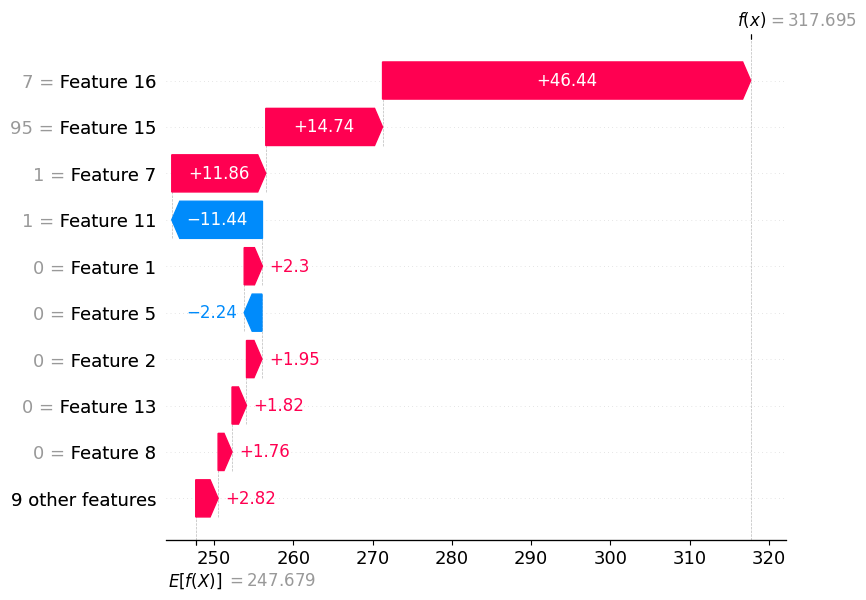

In [11]:
import shap

# Get preprocessed test set
preprocessed_X_test = model.named_steps['preprocessor'].transform(X_test)

# Use trained linear regressor
explainer = shap.Explainer(model.named_steps['regressor'], preprocessed_X_test)
shap_values = explainer(preprocessed_X_test)

# Explain 1 prediction (index 0)
shap.plots.waterfall(shap_values[0], max_display=10)


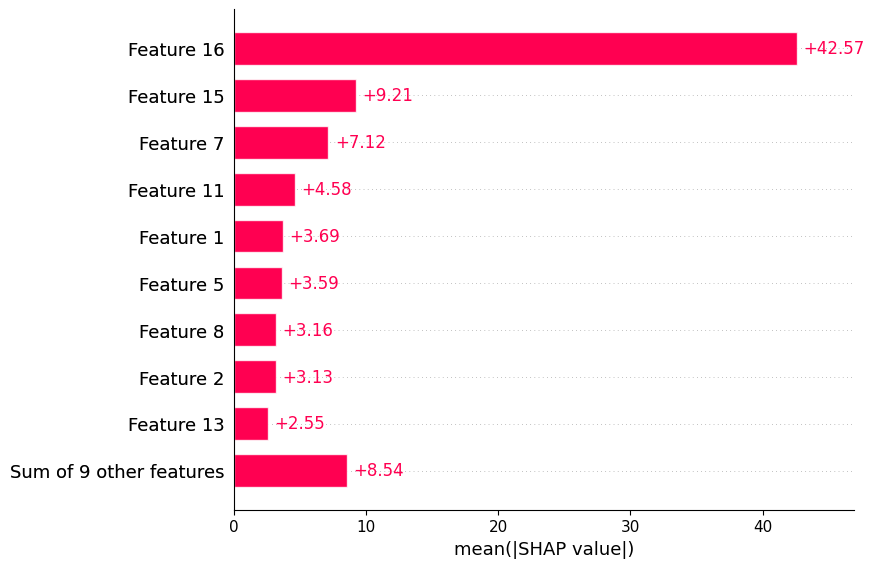

In [12]:
shap.plots.bar(shap_values)


In [13]:
import joblib

# Save pipeline (preprocessor + model)
joblib.dump(model, "ticket_price_model.pkl")
print("Model saved ✅")


Model saved ✅


In [14]:
model = joblib.load("ticket_price_model.pkl")


In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_features = ['event_type', 'location', 'event_day']
numerical_features = ['organizer_rating', 'attendance', 'duration', 'past_revenue']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


In [19]:
model.fit(X_train, y_train)
joblib.dump(model, "ticket_price_model.pkl")  # Save updated model


['ticket_price_model.pkl']

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample
import joblib
import math
# Step 1: Load or Create Dataset
data = pd.read_csv("ticket_price_dataset.csv")  # Replace with your dataset file path

# Step 2: Split X and y
X = data.drop(columns=["ticket_price"])
y = data["ticket_price"]

# Step 3: Define Columns
categorical_features = ['event_type', 'location', 'event_day']
numerical_features = ['organizer_rating', 'attendance', 'duration', 'past_revenue']

# Step 4: Build Preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# Step 5: Build Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Step 6: Train-Test Split and Train Model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Step 7: Evaluate
y_pred = model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
# Step 8: Save the Model
joblib.dump(model, "ticket_price_model.pkl")
print("✅ Model saved as ticket_price_model.pkl")

# Step 9: Predict New Input + Confidence Interval
new_event = pd.DataFrame({
    'event_type': ['Tech'],
    'location': ['Delhi'],
    'organizer_rating': [4.7],
    'attendance': [500],
    'duration': [5],
    'past_revenue': [75000],
    'event_day': ['Sunday']
})

# Predict with confidence interval (bootstrapping)
n_iterations = 100
predictions = []

for _ in range(n_iterations):
    X_resample, y_resample = resample(X_train, y_train)
    model.fit(X_resample, y_resample)
    pred = model.predict(new_event)[0]
    predictions.append(pred)

pred_mean = np.mean(predictions)
lower = np.percentile(predictions, 2.5)
upper = np.percentile(predictions, 97.5)

print(f"\n🎟️ Predicted Price: ₹{pred_mean:.2f}")
print(f"📉 95% Confidence Interval: ₹{lower:.2f} – ₹{upper:.2f}")


R2 Score: 0.810381742464849
RMSE: 24.920097694924188
✅ Model saved as ticket_price_model.pkl

🎟️ Predicted Price: ₹263.22
📉 95% Confidence Interval: ₹215.17 – ₹302.26
